In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
  
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

## PCA

In [9]:
DATA = os.path.join("customer_segmentation_data", "df_test_normalised.csv")
df_data = pd.read_csv(DATA)

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_data)

In [11]:
data_normalised = normalize(data_scaled)
data_normalised = pd.DataFrame(data_normalised, columns=df_data.columns)

data_normalised.head()

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low
0,-0.379317,0.243046,0.183296,-0.100738,0.175276,-0.180181,-0.269682,-0.153159,-0.071159,0.711050,-0.080361,-0.059862,-0.097175,-0.040099,-0.067704,-0.046922,-0.124817,-0.092713,0.176694
1,-0.379105,-0.205442,0.183400,-0.087619,0.175375,0.384737,0.171820,-0.153246,-0.071199,-0.070223,-0.080406,-0.059896,0.513833,-0.040121,-0.067742,-0.046948,0.400040,-0.092765,-0.282590
2,-0.442283,0.283838,0.214060,0.389859,-0.332500,-0.210422,-0.314945,0.380514,-0.083102,-0.081962,-0.093848,-0.069909,-0.113485,-0.046829,-0.079067,-0.054797,-0.145766,-0.108273,0.206349
3,-0.278250,-0.150991,0.134791,0.148650,-0.209372,0.438490,-0.090118,-0.112629,-0.052328,-0.051611,-0.059095,0.613041,-0.071460,-0.029487,-0.049788,-0.034505,-0.091787,0.395824,-0.207692
4,-0.286957,0.184365,-0.206523,-0.246233,-0.215972,0.000000,0.130262,-0.116180,-0.053978,-0.053238,-0.060958,-0.045409,-0.073713,-0.030417,-0.051357,0.806769,-0.094681,-0.070328,0.134032


In [12]:
pca = PCA(n_components=2)
data_principal = pca.fit_transform(data_normalised)
data_principal = pd.DataFrame(data_principal)
data_principal.columns = ["P1", "P2"]

data_principal

,P1,P2
0,-0.030427,0.102836
1,0.060589,-0.271079
2,0.189718,0.354697
3,0.193212,-0.397935
4,-0.388253,-0.045308
...,...,...
2622,-0.687076,-0.180373
2623,-0.259925,0.167228
2624,-0.186781,0.074893
2625,0.253759,-0.501942


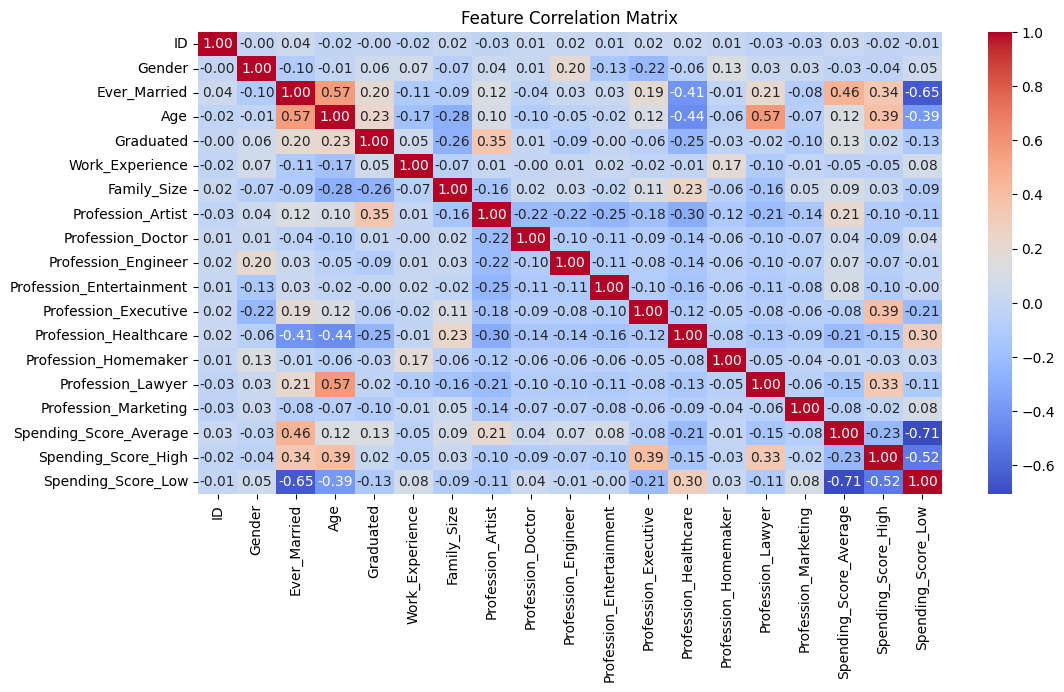

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

We pick age / ever_married columns for segmentation as they have highest score and we can visualise 2 dimentionality

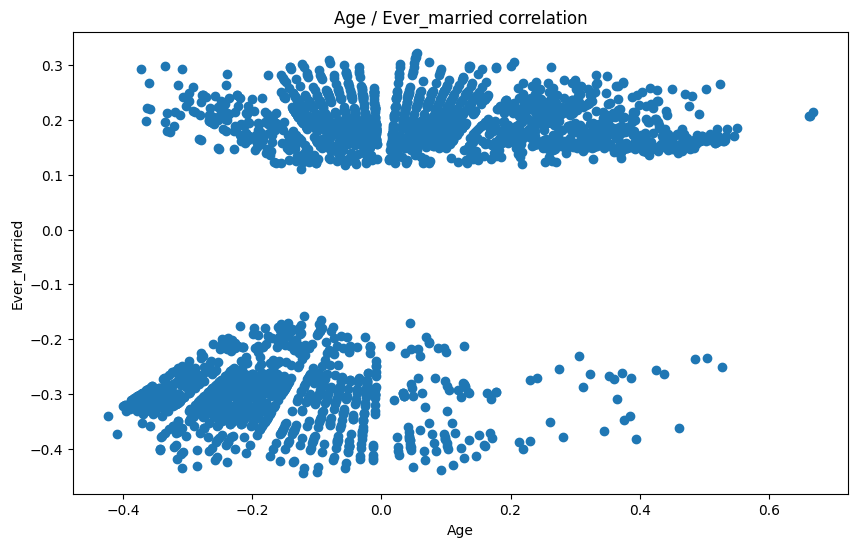

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(data_normalised["Age"], data_normalised["Ever_Married"])
plt.title('Age / Ever_married correlation')
plt.xlabel('Age')
plt.ylabel('Ever_Married')
plt.show()

## Segmentation with DBSCAN

### Running all possible EPS / min_samples combinations

In [15]:
results = []

eps_values = [round(x * 0.1, 1) for x in range(1, 16)]
for EPS in eps_values:
    for samples in range(1,11):
        dbscan = DBSCAN(eps=EPS, min_samples=samples)
        clusters = dbscan.fit_predict(data_normalised)

        data_normalised['Cluster'] = clusters

        x = [EPS, samples, data_normalised['Cluster'].max()]

        results.append(x)

In [16]:
df_results = pd.DataFrame(results, columns=["EPS", "min_samples", "n_clusters"])

we are looking for n of clusters around 4-5

In [17]:
df_results.sort_values(by="n_clusters").head(5)

,EPS,min_samples,n_clusters
9,0.1,10,0
8,0.1,9,0
7,0.1,8,2
6,0.1,7,5
5,0.1,6,10


## Age Family Size

In [18]:
dbscan = DBSCAN(eps=0.1, min_samples=7)
clusters = dbscan.fit_predict(data_normalised)

data_normalised['Cluster'] = clusters

In [19]:
biggest_cluster = data_normalised['Cluster'].mode()[0]
print(f"Biggest cluster is cluster {biggest_cluster}")

data_normalised['Cluster'].max()

Biggest cluster is cluster -1


np.int64(6)

In [20]:
# Reverse normalization
scaler_original = StandardScaler()
scaler_original.fit(df_data[['Age', 'Family_Size']])
original_data_age_family_size = scaler_original.inverse_transform(data_normalised[['Age', 'Family_Size']])
df_original_age_family_size = pd.DataFrame(original_data_age_family_size, columns=['Age', 'Family_Size'])
df_original_age_family_size['Cluster'] = data_normalised['Cluster']

In [21]:
df_original_age_family_size = df_original_age_family_size[df_original_age_family_size['Cluster'] != -1]

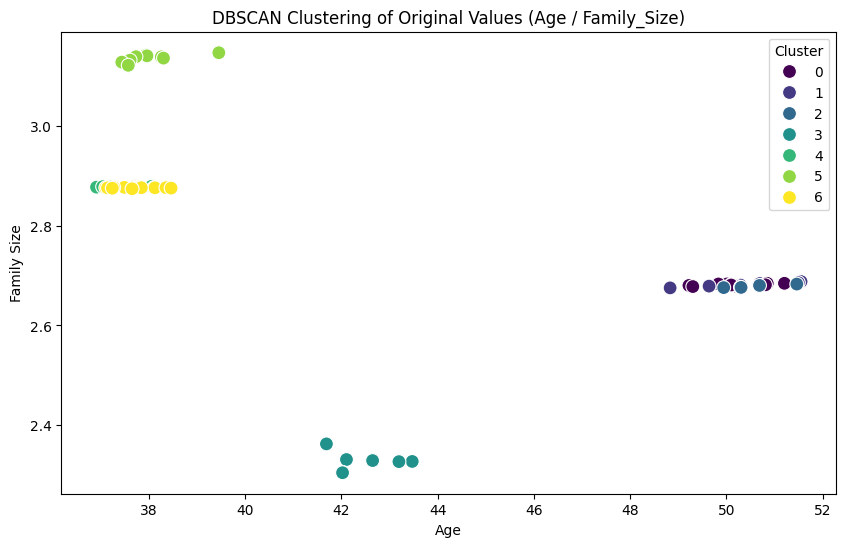

In [22]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_original_age_family_size['Age'], y=df_original_age_family_size['Family_Size'], hue=df_original_age_family_size['Cluster'], palette='viridis', s=100)
plt.title('DBSCAN Clustering of Original Values (Age / Family_Size)')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.legend(title='Cluster')
plt.show()

In [23]:
# Reduce the number of points from the biggest cluster for better visualization
biggest_cluster_points = df_original_age_family_size[df_original_age_family_size['Cluster'] == biggest_cluster]
other_clusters_points = df_original_age_family_size[df_original_age_family_size['Cluster'] != biggest_cluster]

# Sample points from the biggest cluster to reduce overlap (e.g., take 50% of the points)
sampled_biggest_cluster_points = biggest_cluster_points.sample(frac=0.5, random_state=42)

reduced_df_original_age_family_size = pd.concat([sampled_biggest_cluster_points, other_clusters_points])

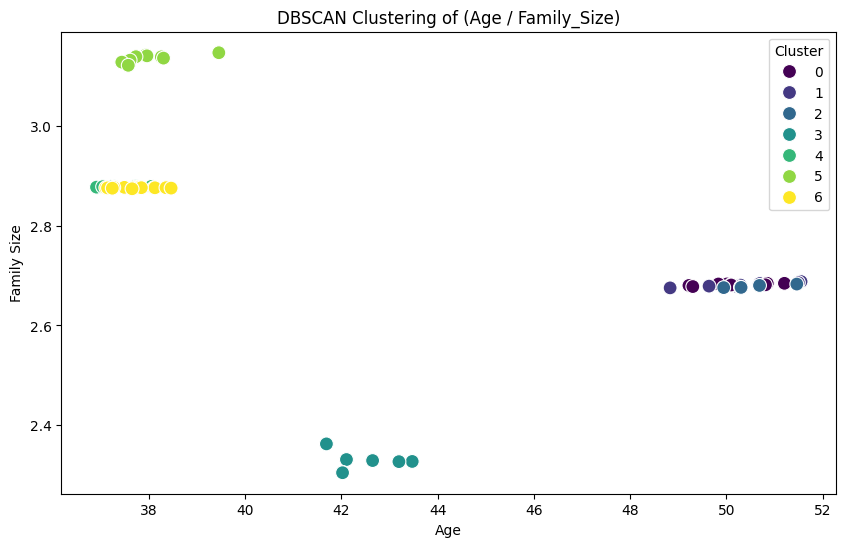

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df_original_age_family_size['Age'], y=reduced_df_original_age_family_size['Family_Size'], hue=reduced_df_original_age_family_size['Cluster'], palette='viridis', s=100)
plt.title('DBSCAN Clustering of (Age / Family_Size)')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.legend(title='Cluster')
plt.show()

In [25]:
biggest_cluster = reduced_df_original_age_family_size['Cluster'].mode()[0]
print(f"Biggest cluster is cluster {biggest_cluster}")

Biggest cluster is cluster 6


## Age Ever Married

In [26]:
biggest_cluster = data_normalised['Cluster'].mode()[0]
print(f"Biggest cluster is cluster {biggest_cluster}")

data_normalised['Cluster'].max()

Biggest cluster is cluster -1


np.int64(6)

In [27]:
scaler_original.fit(df_data[['Age', 'Ever_Married']])
original_data_age_ever_married = scaler_original.inverse_transform(data_normalised[['Age', 'Ever_Married']])
df_original_age_ever_married = pd.DataFrame(original_data_age_ever_married, columns=['Age', 'Ever_Married'])
df_original_age_ever_married['Cluster'] = data_normalised['Cluster']

In [28]:
df_original_age_ever_married = df_original_age_ever_married[df_original_age_ever_married['Cluster'] != -1]


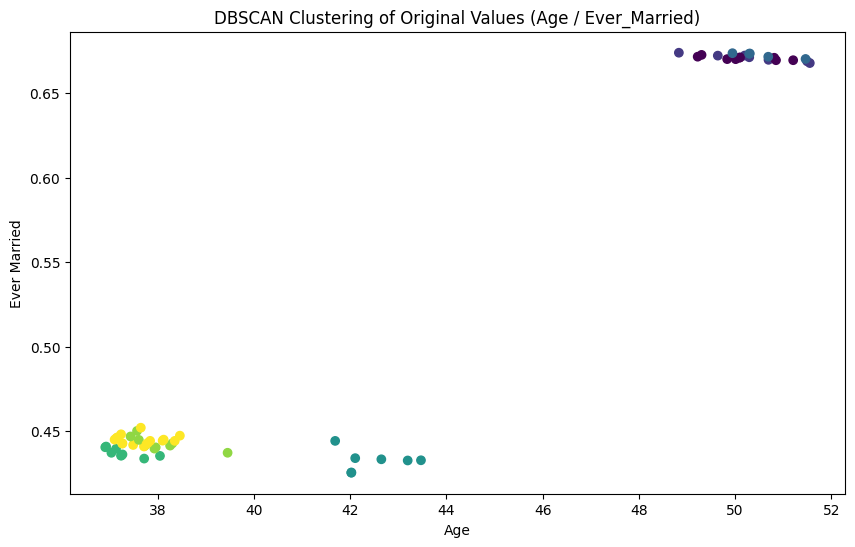

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(df_original_age_ever_married['Age'], df_original_age_ever_married['Ever_Married'], c=df_original_age_ever_married['Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering of Original Values (Age / Ever_Married)')
plt.xlabel('Age')
plt.ylabel('Ever Married')
plt.show()

In [30]:
# Reduce the number of points from the biggest cluster for better visualization
biggest_cluster_points_ever_married = df_original_age_ever_married[df_original_age_ever_married['Cluster'] == biggest_cluster]
other_clusters_points_ever_married = df_original_age_ever_married[df_original_age_ever_married['Cluster'] != biggest_cluster]

# Sample points from the biggest cluster to reduce overlap (e.g., take 50% of the points)
sampled_biggest_cluster_points_ever_married = biggest_cluster_points_ever_married.sample(frac=0.5, random_state=42)

# Combine sampled points with other clusters' points
reduced_df_original_age_ever_married = pd.concat([sampled_biggest_cluster_points_ever_married, other_clusters_points_ever_married])

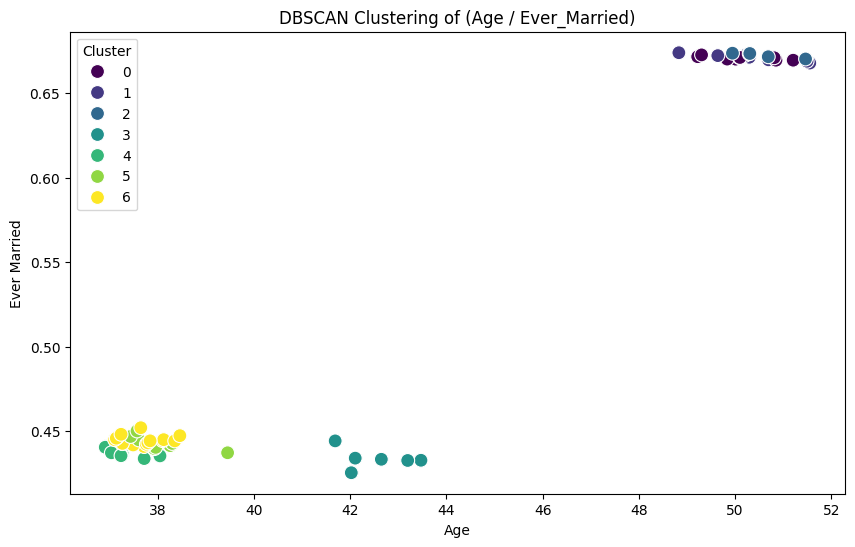

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df_original_age_ever_married['Age'], y=reduced_df_original_age_ever_married['Ever_Married'], hue=reduced_df_original_age_ever_married['Cluster'], palette='viridis', s=100)
plt.title('DBSCAN Clustering of (Age / Ever_Married)')
plt.xlabel('Age')
plt.ylabel('Ever Married')
plt.legend(title='Cluster')
plt.show()

In [32]:
biggest_cluster = reduced_df_original_age_ever_married['Cluster'].mode()[0]
print(f"Biggest cluster is cluster {biggest_cluster}")

Biggest cluster is cluster 6


## Exporting segmentation data into separate files

In [33]:
# Export the reverse normalized DBSCAN segmentation results to CSV files
df_original_age_family_size.to_csv(os.path.join("segmentation_results",'dbscan_segmentation_results_age_family_size.csv'), index=False)
df_original_age_ever_married.to_csv(os.path.join("segmentation_results",'dbscan_segmentation_results_age_ever_married.csv'), index=False)